In [62]:
from FNN_model import *
import xarray as xr
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset

#plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<xarray.DataArray (eof: 30, time: 132001)>
[3960030 values with dtype=float64]
Coordinates:
  * eof      (eof) int32 0 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27 28 29
  * time     (time) object 0001-12-31 12:00:00 ... 11001-12-31 12:00:00 <class 'xarray.core.dataarray.DataArray'>
92400 26400
(30, 92400) (30, 26400) (30, 13201)
[-1.0817188  -1.29517722 -1.55209658 ... -1.25901466 -1.26322655
 -1.28801876] (92400,)


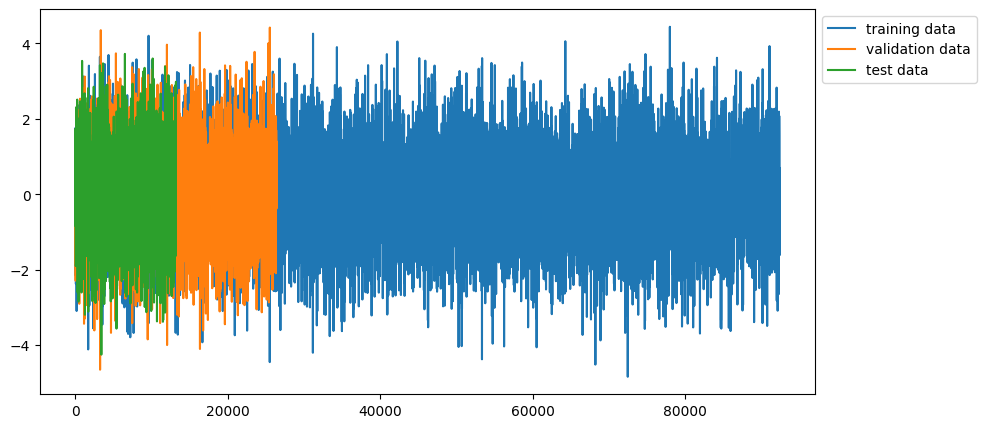

In [63]:
data = xr.open_dataarray("./synthetic_data/lim_integration_xarray_130k[-1]q.nc")

print(data, type(data))

idx_train = int(len(data['time']) * 0.7)
idx_val = int(len(data['time']) * 0.2)
print(idx_train, idx_val)

train_data = data[: :,  :idx_train]
val_data = data[: :, idx_train: idx_train+idx_val]
test_data = data[: :, idx_train+idx_val: ]

train_datan = train_data.data
val_datan = val_data.data
test_datan = test_data.data

print(train_datan.shape, val_datan.shape, test_datan.shape)
print(train_datan[0, :], train_datan[0, :].shape)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_datan[0, :], label='training data')
ax.plot(val_datan[0, :], label='validation data')
ax.plot(test_datan[0, :], label='test data')
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.show()

In [64]:
# Convert to torch.Dataset
input_window = 6
batch_size = 32

train_dataset = TimeSeries(train_data, input_window)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TimeSeries(val_data, input_window)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True)

print("Train dataset: ", train_dataset)

Train dataset:  <FNN_model.TimeSeries object at 0x000001D103B20AC0>


Input shape:  torch.Size([30, 6])
Target shape:  torch.Size([1, 30])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[-1.3373e+00, -1.6089e+00, -1.9224e+00, -1.9488e+00, -1.9034e+00,
         -1.7909e+00],
        [-5.9278e-01, -8.6217e-01, -8.5598e-01, -7.3126e-01, -6.0595e-01,
         -6.4146e-01],
        [ 1.0126e+00,  7.9360e-01,  7.0224e-01,  3.7586e-01,  1.7501e-01,
         -5.7022e-02],
        [ 6.3846e-01,  9.0939e-01,  1.1422e+00,  1.4650e+00,  1.6978e+00,
          1.4270e+00],
        [ 8.5470e-01,  7.0552e-01,  3.8409e-01,  8.1395e-02, -5.2379e-01,
         -7.8768e-01],
        [ 4.4148e-01, -8.0422e-02, -4.0377e-01, -4.2092e-01, -3.7870e-01,
          4.8893e-01],
        [-5.6570e-01, -1.6790e+00, -2.2404e+00, -1.0217e+00,  1.9252e-02,
          2.2882e-01],
        [ 2.1968e-01, -3.9160e-01, -7.7503e-01, -2.6930e-01, -5.7000e-01,
         -1.1072e+00],
        [ 2.7480e+00,  2.5403e+00,  1.5417e+00,  1.6262e-01, -1.7458e+00,
         -3.1437e+00],
 

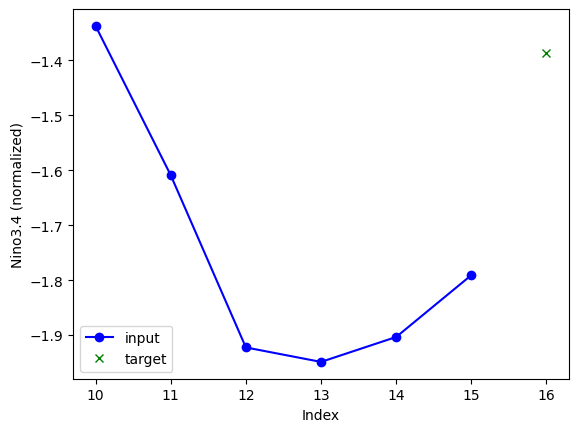

In [67]:
# Sample datapoint
input, target, l = train_dataset[10]

fig, ax = plt.subplots()
ax.plot(l['idx_input'], input[0, :], 'bo-', label='input')
ax.plot(l['idx_target'], target[: , 0], 'gx', label='target')
ax.set_xlabel("Index")
ax.set_ylabel("Nino3.4 (normalized)")
_ = ax.legend()
print(l['month'])
print(input)
print(target)

In [ ]:
# Setting hyperparameters for training
num_features = 30
hidden_size = 64
num_layers = 2
learning_rate = 0.001
num_epochs = 100
input_window = input_window
output_window = 12
batch_size = 64
training_prediction = "recursive"
teacher_forcing_ratio = 0.5
dynamic_tf = True
shuffle = True
loss_type = "L1"
wind_farm = "britain_time_lag_corr_"

print("Start training")

# Specify the device to be used for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

output_dim = 1

model = FeedforwardNetwork(input_size = num_features, hidden_size = hidden_size, output_size=output_dim)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loss, loss_test = model.train_model(train_dataloader,
                                    val_dataloader,                       num_epochs,
                                    input_window,
                                    output_window,
                                    batch_size,
                                    training_prediction,
                                    teacher_forcing_ratio,
                                    learning_rate,
                                    dynamic_tf,
                                    loss_type,
                                    optimizer, num_features)


rand_identifier = str(np.random.randint(0, 10000000)) + "fnn"
print(f"Model saved as model_{rand_identifier}.pt")

# Save the model and hyperparameters to a file
parameters = {
    'hidden_size': hidden_size,
    "num_layers": num_layers,
    'learning_rate': learning_rate,
    'num_epochs': num_epochs,
    "input_window": input_window,
    "output_window": output_window,
    "batch_size": batch_size,
    "training_prediction": training_prediction,
    "teacher_forcing_ratio": teacher_forcing_ratio,
    "dynamic_tf": dynamic_tf,
    "loss": loss.tolist(),
    "loss_test": loss_test.tolist(),
    "loss_type": loss_type,
    "shuffle": shuffle,
    "wind_farm": wind_farm,
}

torch.save({'hyperparameters': parameters,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()},
           f'./trained_models/model_{rand_identifier}.pt')